In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
# Load data
data = pd.read_csv(file_path)
# data['is_correct'] = (
#     ((data['test_dur'] > data['standard_dur']) & (data['response'] == data['test_order'])) | 
#     ((data['test_dur'] < data['standard_dur']) & (data['response'] != data['test_order'])) |
#     ((data['test_dur'] == data['standard_dur']) & (data['response'] == np.random.choice([0, 1], size=len(data))))
# ).astype(int)



# 2AFC P Correct

In [3]:
# Group by both delta_dur and rise_dur
grouped_by_delta_dur_rise_dur = data.groupby(['delta_dur', 'rise_dur'])

# Compute the total responses and correct responses for each condition
summary = grouped_by_delta_dur_rise_dur.agg(
    total_responses=('response', 'count'),
    correct_responses=('is_correct', 'sum')  # Assuming 1 = correct, 0 = incorrect
).reset_index()

# Calculate P(correct)
summary['p_correct'] = summary['correct_responses'] / summary['total_responses']

# Display the summary dataframe
from IPython.display import display

# Display the summary dataframe
display(summary)

# Rise dur =0.1
rise_dur_01 = summary[summary['rise_dur'] == 0.1]
rise_dur_02 = summary[summary['rise_dur'] == 0.2]

# Format the data for each psychometric function as a nx3 matrix
# with columns for the stimulus level, the number of correct responses and the number of total responses.
psychometric_data_rise1 = rise_dur_01[['delta_dur', 'correct_responses', 'total_responses']].values
psychometric_data_rise2 = rise_dur_02[['delta_dur', 'correct_responses', 'total_responses']].values


KeyError: "Column(s) ['is_correct'] do not exist"

In [ ]:

result_01 = ps.psignifit(psychometric_data_rise1,  experiment_type='2AFC')
result_02 = ps.psignifit(psychometric_data_rise2,  experiment_type='2AFC')


In [ ]:
print(result_01.parameter_estimate)
plt.figure()
psigniplot.plot_psychometric_function(result_01, plot_data=True)
psigniplot.plot_psychometric_function(result_02, plot_data=True, line_color='red',data_color='r')
plt.show()

# Psignifit fitting Yes No P choice

In [11]:
import psignifit as ps
from psignifit import psigniplot
# Step 1: Calculate whether participant chose "test" stimulus
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur and rise_dur to calculate P(choose test)
grouped = data.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Calculate the proportion of "test chosen" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

# Display the summary dataframe
display(grouped)

# Format the data for Psignifit
psychometric_data_rise1 = grouped[grouped['rise_dur'] == 0.05][['delta_dur_adjusted', 'chose_test', 'total_responses']].values
psychometric_data_rise2 = grouped[grouped['rise_dur'] == 0.245][['delta_dur_adjusted', 'chose_test', 'total_responses']].values


# Fit psychometric function using 2AFC
result_01 = ps.psignifit(psychometric_data_rise1, experiment_type='yes/no')
result_02 = ps.psignifit(psychometric_data_rise2, experiment_type='yes/no')



,delta_dur_adjusted,rise_dur,total_responses,chose_test,p_choose_test
0,-0.760870,0.245,2,0,0.0
1,-0.684783,0.245,1,0,0.0
2,-0.586957,0.050,1,0,0.0
3,-0.586957,0.245,1,0,0.0
4,-0.543478,0.050,2,1,0.5
...,...,...,...,...,...
132,0.849130,0.050,2,1,0.5
133,0.914348,0.050,2,1,0.5
134,0.914565,0.245,1,1,1.0
135,1.028696,0.050,1,1,1.0


/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/psignifit/psignifit.py:144: UserWarning: Expects at most 25 blocks in data, got 65.
To save fitting time, consider aggregating blocks of same stimulus level psignifit.pool_blocks(data).
Hide this warning by increasing conf.pool_max_blocks.
  warnings.warn(f"Expects at most {pool_max_blocks} blocks in data, got {len(levels)}.\n"
/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/psignifit/psignifit.py:150: UserWarning: The data you supplied contained 65>= 25 stimulus levels.
            Did you sample adaptively?
            If so please specify a range which contains the whole psychometric function in
            conf.stimulus_range.
            An appropriate prior prior will be then chosen. For now we use the standard
            heuristic, assuming that the psychometric function is covered by the stimulus
            levels,which is frequently invalid for adaptive procedures!
  warnings.warn(f"""The data you supplied c

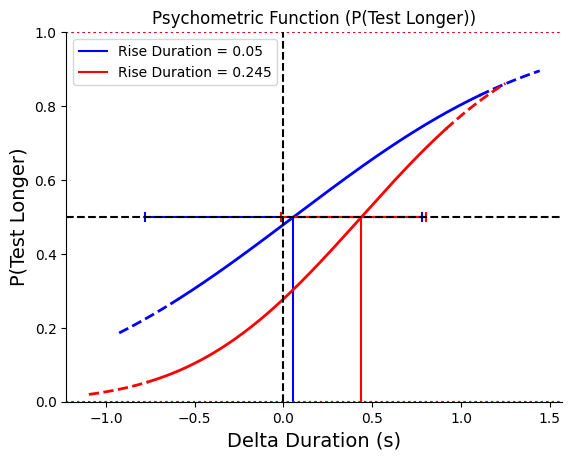

In [16]:

# Plot psychometric function
plt.figure()
psigniplot.plot_psychometric_function(result_01, line_color='blue', data_color='b',plot_data=False) # label rise duration = 0.1
psigniplot.plot_psychometric_function(result_02,line_color='red', data_color='r',plot_data=False) # label rise duration = 0.2

# Customize plot
plt.title('Psychometric Function (P(Test Longer))')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlabel('Delta Duration (s)')
plt.ylabel('P(Test Longer)')

handles =[plt.Line2D([0], [0], color='blue', label='Rise Duration = 0.05'),
            plt.Line2D([0], [0], color='red', label='Rise Duration = 0.245')]
plt.legend(handles=handles)
plt.show()


In [8]:
import numpy as np
from scipy.optimize import curve_fit

# Extract delta durations and responses
x = summary['delta_dur'].values
n_trials = summary['total_responses'].values
n_correct = summary['correct_responses'].values
p_correct = n_correct / n_trials

# Define the logistic function
def logistic(x, mu, sigma):
    return 1 / (1 + np.exp(-(x - mu) / sigma))

# Fit the logistic function to the data
params, _ = curve_fit(logistic, x, p_correct, p0=[0, 0.5])

# Extract the fitted parameters
mu, sigma = params

print(f"Estimated mu: {mu}")
print(f"Estimated sigma: {sigma}")

# Plot the data and the fitted logistic function
x_values = np.linspace(-0.5, 0.5, 1000)
y_values = logistic(x_values, mu, sigma)

plt.figure(figsize=(10, 6))
plt.scatter(x, p_correct, s=n_trials, c='b', alpha=0.5)
plt.plot(x_values, y_values, 'r-', label='Logistic fit')
plt.xlabel('Delta Duration (s)')
plt.ylabel('P(Correct)')
plt.title('Psychometric Function')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'summary' is not defined

Rise Duration 0.1s - λ: 0.5113, μ: -0.0233, σ: 0.8127
Rise Duration 0.2s - λ: 0.0000, μ: 0.4510, σ: 0.7862


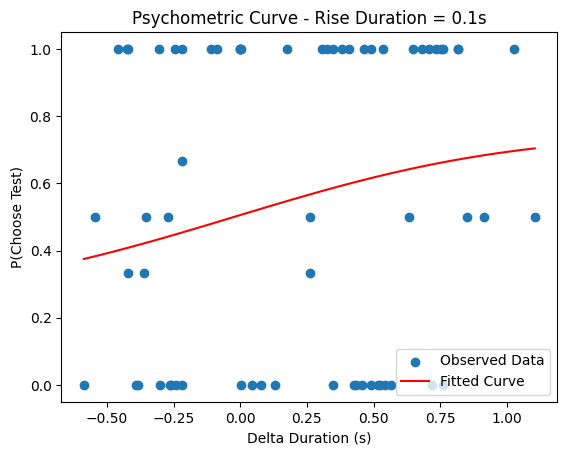

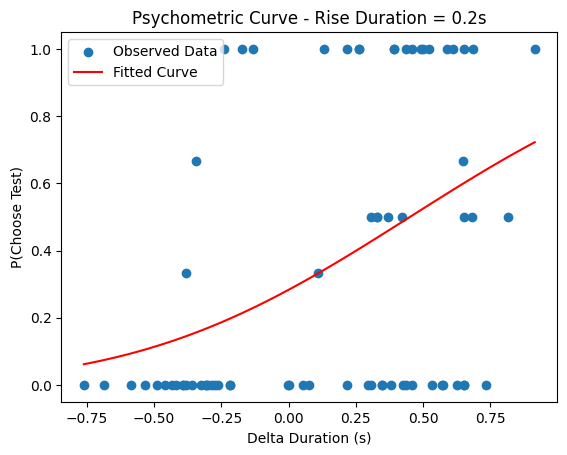

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Load your pilot data

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur and rise_dur
grouped = data.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Step 3: Calculate the proportion of "choose test" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

# Step 4: Extract data for rise_dur = 0.1 and 0.2
psychometric_data_rise1 = grouped[grouped['rise_dur'] == 0.05][['delta_dur_adjusted', 'chose_test', 'total_responses']].values
psychometric_data_rise2 = grouped[grouped['rise_dur'] == 0.245][['delta_dur_adjusted', 'chose_test', 'total_responses']].values


# Define psychometric function
def psychometric_function(delta_dur, lambda_, mu, sigma):
    p = (1 - lambda_) * norm.cdf(delta_dur, loc=mu, scale=sigma) + lambda_ / 2
    return p

# Negative log-likelihood function
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric curve for a given dataset (rise_dur = 0.1)
def fit_psychometric_curve(data):
    delta_dur = data[:, 0]
    chose_test = data[:, 1]
    total_responses = data[:, 2]
    
    # Initial guess and bounds for [lambda, mu, sigma]
    initial_guess = [0.05, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-1, 1), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0
    
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(delta_dur, chose_test, total_responses), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

# Fit parameters for rise_dur = 0.1
lambda_r1, mu_r1, sigma_r1 = fit_psychometric_curve(psychometric_data_rise1)
print(f"Rise Duration 0.1s - λ: {lambda_r1:.4f}, μ: {mu_r1:.4f}, σ: {sigma_r1:.4f}")

# Fit parameters for rise_dur = 0.2
lambda_r2, mu_r2, sigma_r2 = fit_psychometric_curve(psychometric_data_rise2)
print(f"Rise Duration 0.2s - λ: {lambda_r2:.4f}, μ: {mu_r2:.4f}, σ: {sigma_r2:.4f}")

# Plot the results
def plot_psychometric_curve(delta_dur, chose_test, total_responses, lambda_, mu, sigma, rise_dur):
    p_hat = chose_test / total_responses
    plt.scatter(delta_dur, p_hat, label='Observed Data')
    
    delta_dur_range = np.linspace(min(delta_dur), max(delta_dur), 100)
    p_curve = psychometric_function(delta_dur_range, lambda_, mu, sigma)
    plt.plot(delta_dur_range, p_curve, label='Fitted Curve', color='red')
    
    plt.xlabel('Delta Duration (s)')
    plt.ylabel('P(Choose Test)')
    plt.title(f'Psychometric Curve - Rise Duration = {rise_dur}s')
    plt.legend()
    plt.show()

# Plot the psychometric curves for both rise durations
plot_psychometric_curve(psychometric_data_rise1[:, 0], 
                        psychometric_data_rise1[:, 1], 
                        psychometric_data_rise1[:, 2], 
                        lambda_r1, mu_r1, sigma_r1, 
                        rise_dur=0.1)

plot_psychometric_curve(psychometric_data_rise2[:, 0], 
                        psychometric_data_rise2[:, 1], 
                        psychometric_data_rise2[:, 2], 
                        lambda_r2, mu_r2, sigma_r2, 
                        rise_dur=0.2)
